In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit
from scipy.stats import poisson
import os
file_path = r'C:\Users\samle\source\repos\prosthetic_claw_sim'

In [38]:

class EMGSimulator:
    def __init__(self, force):
        
        self.duration = 10
        self.force_slope = force/self.duration
        self.sampling_rate = 100
        self.time = np.arange(0, self.duration, 1/self.sampling_rate)
        self.force_profile = self.force_slope * self.time
        self.force_value = self.force_slope * self.duration
        self.force_thresholds = {1: [0,20], 2: [20,40], 3: [40,60]}
        self.max_firing_rates = {1: 3, 2: 3, 3: 3}
        self.muap_params = {
    1: [0.2, 0.2, 0.1, 0.15, 0.02],
    2: [0.6, 0.6, 0.08, 0.12, 0.03],
    3: [1.4, 1.4, 0.1, 0.15, 0.02]
}


    @staticmethod
    def generate_biphasic_muap(t, muap_params, force_level):
        A1, A2, T1, T2, std = muap_params
        return force_level * (A1 * np.exp(-((t - T1)**2) / (2 * std**2)) - A2 * np.exp(-((t - T2)**2) / (2 * std**2)))

    def calculate_firing_rates(self):
        firing_rates = {}
        for motor_unit in self.force_thresholds.keys():
            firing_rates[motor_unit] = np.zeros_like(self.time)
            min_force, max_force = self.force_thresholds[motor_unit]
            for i, force in enumerate(self.force_profile):
                if force <= min_force:
                    firing_rates[motor_unit][i] = 0
                elif force > max_force:
                    firing_rates[motor_unit][i:] = self.max_firing_rates[motor_unit]
                    break
                else:
                    firing_rates[motor_unit][i] = self.max_firing_rates[motor_unit] * (2 * expit(10 * (force - min_force) / (max_force - min_force)) - 1)
        return firing_rates

    def generate_spike_trains(self, firing_rates):
        spike_trains = {}
        for motor_unit in firing_rates.keys():
            spike_trains[motor_unit] = np.zeros_like(self.time)
            for i, rate in enumerate(firing_rates[motor_unit]):
                spike_trains[motor_unit][i] = poisson.rvs(rate/self.sampling_rate)  # convert rate from Hz to spikes per sample
        return spike_trains

    def generate_emg(self, spike_trains):
        # Generate MUAP templates
        muap_templates = {}
        for motor_unit, params in self.muap_params.items():
            muap_templates[motor_unit] = self.generate_biphasic_muap(self.time, params, force_level=1)

        # Generate motor unit action potentials
        muaps = {}
        for motor_unit, spike_train in spike_trains.items():
            muap = np.zeros_like(self.time)
            for i, spike in enumerate(spike_train):
                if spike:
                    start = i
                    end = start + len(muap_templates[motor_unit])
                    if end > len(muap):
                        end = len(muap)
                        muap[start:end] += muap_templates[motor_unit][:end-start]
                    else:
                        muap[start:end] += muap_templates[motor_unit]
            muaps[motor_unit] = muap

        # Initialize EMG signal as zero
        emg = np.zeros_like(self.time)

        # Add each MUAP to the EMG signal
        for muap in muaps.values():
            emg += muap

        return emg, muaps

    def export_to_csv(self, emg):
        df = pd.DataFrame({
        'time': self.time,
        'emg': emg
        })
        if file_path:
            save_path = os.path.join(file_path, "emg.csv")
            df.to_csv(save_path, index=False)
            print(f"EMG data saved to {save_path}")

        # df.to_csv(f'{file_path}\emg.csv', index=False)
      
    def plot_emg(self, emg, file_path=""):
        plt.figure(figsize=(10, 6))
        
        # Plot EMG
        plt.plot(self.time, emg, label="EMG Signal")
        plt.xlabel("Time (s)")
        plt.ylabel("EMG Amplitude")
        plt.title("EMG Signal Over Time")
        plt.grid(True)
        plt.legend()

        # Save plot if file_path is given
        if file_path:
            save_path = os.path.join(file_path, "emg_signal.png")
            plt.savefig(save_path)
            print(f"EMG plot saved to {save_path}")

        plt.show()

    def run_simulation(self):
        # Calculate firing rates for motor units
        firing_rates = self.calculate_firing_rates()
        
        # Generate spike trains based on firing rates
        spike_trains = self.generate_spike_trains(firing_rates)
        
        # Generate electromyography (EMG) and motor unit action potentials (MUAPs) using spike trains
        emg, muaps = self.generate_emg(spike_trains)
        
        
        # Export EMG data to a MATLAB file
        self.export_to_csv(emg)
        
        # Plot firing rates, spike trains, EMG, and MUAPs
        self.plot_emg(emg)

EMG data saved to C:\Users\samle\source\repos\prosthetic_claw_sim\emg.csv


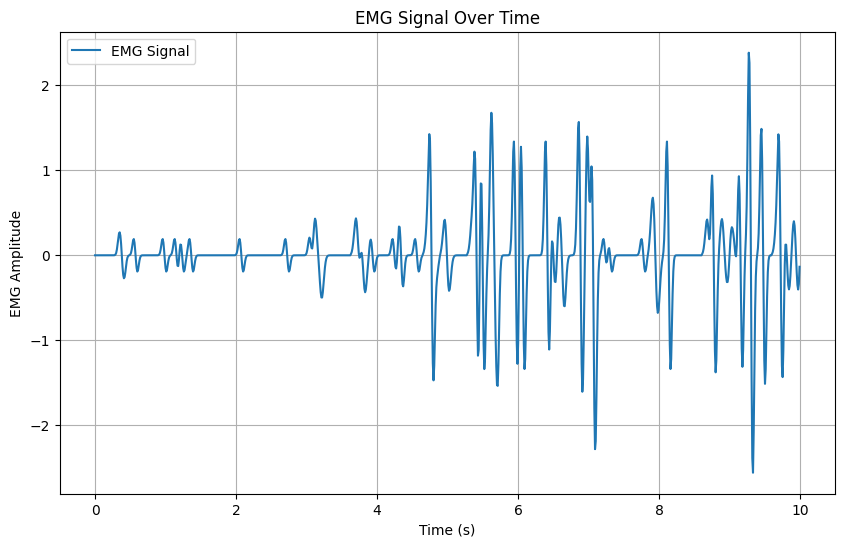

In [39]:
if __name__ == "__main__":
    simulator = EMGSimulator(force=100)
    simulator.run_simulation()